In [18]:
import numpy as np
from scipy import linalg

#import handwritten digits dataset
from sklearn.datasets import load_digits

#used in _kl_divergence
#sum|xi-xj|^2
from scipy.spatial.distance import pdist #sqeuclidean

#used in fit (fit data to t-SNE)
#convert distances to joint prob
from sklearn.metrics import pairwise_distances #euclidean #sum|xi-xj|
from sklearn.manifold._t_sne import _joint_probabilities

#compute distance between every pairwises in a matrix nxn, and return a vector of distance for n(n-1)/2 edges
#or vice-versa
from scipy.spatial.distance import squareform

#for plotting
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

#t-SNE using sklearn
from sklearn.manifold import TSNE

In [5]:
X, y = load_digits(return_X_y=True)

In [7]:
MACHINE_EPSILON = np.finfo(np.double).eps
n_components = 2
perplexity = 30 #default to 30 neighbors

In [8]:
def fit(X):
    n_samples = X.shape[0]
    
    # Compute euclidean distance
    distances = pairwise_distances(X, metric='euclidean', squared=True)
    
    # Compute joint probabilities p_ij from distances.
    P = _joint_probabilities(distances=distances, desired_perplexity=perplexity, verbose=False)
    
    # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
    X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, n_components).astype(np.float32)
    
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(n_components - 1, 1)
    
    return _tsne(P, degrees_of_freedom, n_samples, X_embedded=X_embedded)

In [10]:
def _tsne(P, degrees_of_freedom, n_samples, X_embedded):
    params = X_embedded.ravel()
    obj_func = _kl_divergence    
    params = _gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, n_components])        
    X_embedded = params.reshape(n_samples, n_components)
    
    return X_embedded

In [12]:
def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components):
    X_embedded = params.reshape(n_samples, n_components)
    
    dist = pdist(X_embedded, "sqeuclidean")
    dist /= degrees_of_freedom
    dist += 1.
    dist **= (degrees_of_freedom + 1.0) / -2.0
    Q = np.maximum(dist / (2.0 * np.sum(dist)), MACHINE_EPSILON)
    
    # Kullback-Leibler divergence of P and Q
    kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    # Gradient: dC/dY
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist)
    for i in range(n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                         X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad *= c
    return kl_divergence, grad

In [13]:
def _gradient_descent(obj_func, p0, args, it=0, n_iter=1000,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7):
    
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it
    
    for i in range(it, n_iter):
        error, grad = obj_func(p, *args)
        grad_norm = linalg.norm(grad)
        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update
        print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
        
        if error < best_error:
                best_error = error
                best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        
        if grad_norm <= min_grad_norm:
            break
    return p

In [14]:
X_embedded = fit(X)

C:\Users\JRRex\AppData\Local\Temp/ipykernel_17052/274475118.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\JRRex\AppData\Local\Temp/ipykernel_17052/274475118.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000049
[t-SNE] Iteration 2: error = 4.0229676, gradient norm = 0.0000049
[t-SNE] Iteration 3: error = 4.0229676, gradient norm = 0.0000060
[t-SNE] Iteration 4: error = 4.0229676, gradient norm = 0.0000091
[t-SNE] Iteration 5: error = 4.0229676, gradient norm = 0.0000154
[t-SNE] Iteration 6: error = 4.0229674, gradient norm = 0.0000279
[t-SNE] Iteration 7: error = 4.0229667, gradient norm = 0.0000540
[t-SNE] Iteration 8: error = 4.0229640, gradient norm = 0.0001109
[t-SNE] Iteration 9: error = 4.0229511, gradient norm = 0.0002401
[t-SNE] Iteration 10: error = 4.0228849, gradient norm = 0.0005466
[t-SNE] Iteration 11: error = 4.0225099, gradient norm = 0.0013016
[t-SNE] Iteration 12: error = 4.0202082, gradient norm = 0.0032067
[t-SNE] Iteration 13: error = 4.0055221, gradient norm = 0.0077674
[t-SNE] Iteration 14: error = 3.9244528, gradient norm = 0.0152093
[t-SNE] Iteration 15: error = 3.6685438, gradient norm = 0.0187481
[t-S

c:\Users\JRRex\Desktop\Exercise Session\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

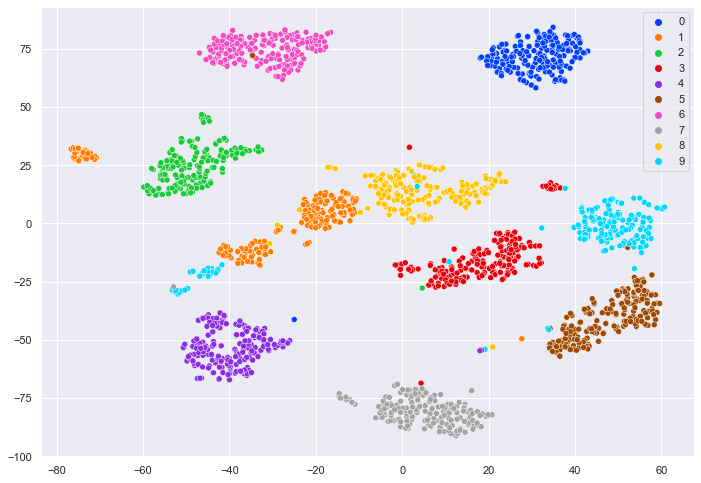

In [15]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)

## t-SNE using sklearn

In [16]:
tsne = TSNE()
X_embedded = tsne.fit_transform(X)

c:\Users\JRRex\Desktop\Exercise Session\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

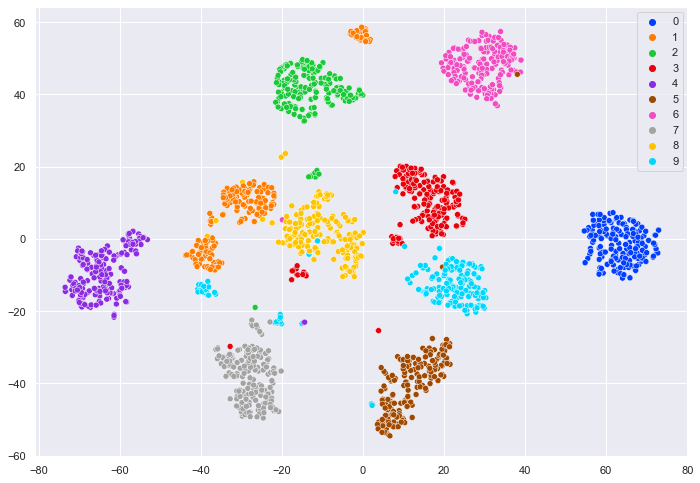

In [17]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette)